# Image recognition using ResNet50 for Coursera's Convolutional Neural Networks course

The ResNet50 model is applied to sign language digits. We use a set of pre-trained weights from Coursera, applied to the same dataset. The predictions are highly accurate (~90%) on the test set but when applied to other images from other sources, the model has significantly lower accuracy (~20%).

The issue of generalization / overfitting is partly resolved here by re-training the weights on a dataset that includes images from other sources.

After re-training, the model becomes much more accurate on images from the other sources.

Due to limited computational resources, we have only trained the model on a few epochs. But this work establishes the principle.

## 1. Implementing and applying the model

The ResNet50 model (implemented [here](./resnet_utils.py)) is applied to an image recognition problem: identifying the number of fingers that are being held up (aka "sign language digits"). Images are hand gestures showing numbers 0-5, cropped to only show the hand. 

The model is trained on a set of images of sign language digits provided by Coursera. Here is an example:

<img src='./images/my_image.jpg' alt="2" style="width:200px;"/>

The predictions are compared with those of a model that uses pre-trained weights on the same dataset (these pre-trained weights are also provided by the course). We call this the *pre-trained model*.

In [5]:
# import libraries

import numpy as np
import scipy.misc
import glob

import pydot

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, plot_model
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
import keras.backend as K

from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from imageio import imread

from resnets_utils import *

import warnings
warnings.filterwarnings('ignore')

K.set_image_data_format('channels_last')
K.set_learning_phase(1)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Load Coursera data
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [16]:
# Load ResNet50 model
model = ResNet50(input_shape = (64, 64, 3), classes = 6) # build graph

# First compile model before training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit model
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

In [ ]:
# Make predictions
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

In [ ]:
# Save model weights
model.save_weights('my_ResNet50_weights.h5')

In [29]:
# Load pre-trained weights (from Coursera) for ResNet50 ('pre-trained model')
model = load_model('ResNet50.h5') 

In [30]:
# Make predictions
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 13s 107ms/step
Loss = 0.2556911051273346
Test Accuracy = 0.9166666706403096


## 2. Example of *overfitting*

The pre-trained model is then applied to a *different* set of images of sign language digits:

see: ["Turkey AAA (High School's Sign Language Digits) dataset"](https://github.com/ardamavi/Sign-Language-Digits-Dataset)

Here is an example:

<img src='./Sign-Language-Digits-Dataset/Dataset/2/IMG_1171.JPG' alt="2" style="width:200px;"/>

The accuracy of the pre-trained model is significantly lower on the Turkey AAA dataset, indicating that the model is overfitted.



In [34]:
# Load images for Turkey AAA high school data
img_folder_path='./Sign-Language-Digits-Dataset/Dataset/'

X = []
Y = []    
for i in range(6):
    cur_folder = img_folder_path+ str(i) + '/'
    cur_files = glob.glob(cur_folder + '*.JPG')
    for file in cur_files:
        img = image.load_img(file, target_size=(64, 64))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        X.append(x)
        Y.append(i)

In [35]:
# Reshaping arrays
X = np.array(X).reshape((len(X),64,64,3))
Y = np.array(Y).reshape((len(Y),1))

# Normalize image vectors
X = X / 255.

# Convert to one hot matrices
Y = convert_to_one_hot(Y, 6).T

In [33]:
# Make predictions on Turkey AAA high school data
preds = model.evaluate(X,Y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1237/1237 [==============================] - 43s 35ms/step
Loss = 5.83856439320619
Test Accuracy = 0.22877930487801976


## 3. Troubleshooting and re-training

Assuming no implementation errors, there are two possible causes of overfitting:

1. **Model complexity issue**. The model contains too many parameters, relative to the problem 'complexity'. As a result, the model is also modeling noise, not just signal.

2. **Data generalization issue**. The training data and test data are drawn from different distributions.

We re-train the weights of the last layer of the network, freezing all other weights. We use a training set that represents a combination of the Coursera dataset and the Turkey High School dataset.

We show that upon re-training the final layer of the network, the accuracy increases.

In [36]:
# Split up Turkey AAA high school data set into training and test sets

# Set parameters for splitting training and test set
test_size = 0.2 # percent of samples to put in test set
random_state = 1 # RNG seed for picking which samples go into training vs test set

X_train_2, X_test_2, Y_train_2, Y_test_2_ = train_test_split(X, Y, test_size=test_size, random_state=random_state)

print ("number of training examples = " + str(X_train_2.shape[0]))
print ("number of test examples = " + str(X_test_2.shape[0]))
print ("X_train_2 shape: " + str(X_train_2.shape))
print ("Y_train_2 shape: " + str(Y_train_2.shape))
print ("X_test_2 shape: " + str(X_test_2.shape))
print ("Y_test_2 shape: " + str(Y_test_2.shape))

number of training examples = 989
number of test examples = 248
X_train_2 shape: (989, 64, 64, 3)
Y_train_2 shape: (989, 6)
X_test_2 shape: (248, 64, 64, 3)
Y_test_2 shape: (248, 6)


In [40]:
# Combine Coursera training dataset and 
X_train = np.concatenate((X_train, X_train_2),axis=0)
Y_train = np.concatenate((Y_train, Y_train_2),axis=0)

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

X_train shape: (2069, 64, 64, 3)
Y_train shape: (2069, 6)


In [20]:
# Freeze all but last layer
for layer in model.layers[:-1]:
   layer.trainable = False

In [21]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Fit model (takes around ~1 minute per epoch on my 2013 Macbook Air)
model.fit(X_train, Y_train, epochs = 3, batch_size = 32)

Epoch 1/3
2069/2069 [==============================] - 74s 36ms/step - loss: 1.1070 - acc: 0.7100
Epoch 2/3
2069/2069 [==============================] - 75s 36ms/step - loss: 0.7662 - acc: 0.7260
Epoch 3/3
2069/2069 [==============================] - 72s 35ms/step - loss: 0.7339 - acc: 0.7414


In [27]:
# Make predictions on Turkey AAA high school data
preds = model.evaluate(X_test_2, Y_test_2)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

248/248 [==============================] - 11s 44ms/step
Loss = 1.41725714360514
Test Accuracy = 0.5282258045288825


In [28]:
# Make predictions on Coursera data
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 4s 33ms/step
Loss = 0.27473118106524147
Test Accuracy = 0.9166666626930237


In [12]:
# Model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

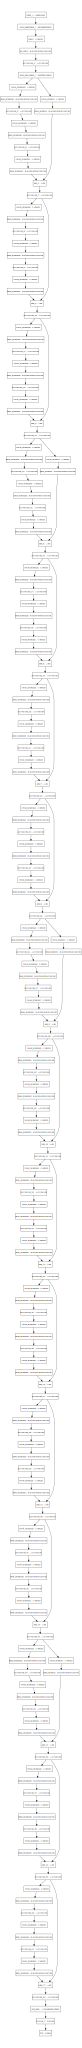

In [12]:
# Save model architecture
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))